In [1]:
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
model = 0     # spin model - 0; schooling model - 1
mod = 'NN' if model == 0 else 'SPP'

distances = [100, 200, 400, 1000, 2000, 4000, 10000, 20000, 40000, 100000]
neurons = [6, 12, 24, 60, 120, 240, 600]

In [3]:
nbins = 500
peak_threshold = 0.95


def density_map(x, y, stats=True):
    blur = (11, 11) if stats == True else (71, 71)
    r = [[0, post0_x], [post0_y, post1_y]]
    h, xedge, yedge, image = plt.hist2d(x, y, bins=nbins, normed=True, range=r)

    tmp_img = np.flipud(np.rot90(cv2.GaussianBlur(h, blur, 0)))

    for i in range(0, nbins):
        max_val = np.nanmax(tmp_img[:, i])
        tmp_img[:, i] = tmp_img[:, i] / max_val if max_val > 0 else tmp_img[:, i]

    return tmp_img

def fitfunc(x, p, q):
    if x < p:
        return 0
    else:
        return np.abs(x - p) ** q

def fitfunc_vec_self(x, p, q):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i] = fitfunc(x[i], p, q)
    return y

def exponenial_func(x, a, b, c):
    return a * np.exp(-b * x) + c

### Visualise change in bifurcation point based on distance to target

In [ ]:
n_iters = 100
b_angles = []

for d in distances:
    df = pd.read_csv("/Users/vivekhsridhar/Documents/Work/Results/decision_geometry/Data/Theory/NN/distance" + str(d) + ".csv")

    xs = np.array(df[' x'])
    ys = np.array(df[' y'] - 500)
    
    post0_x = d*np.cos(np.pi/6)
    post0_y = -d*np.sin(np.pi/6)
    post1_x = d*np.cos(np.pi/6)
    post1_y = d*np.sin(np.pi/6)
    
    img = density_map(xs, ys, stats=False)
    x_peaks = np.where(img > peak_threshold)[1] * post0_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post1_y) / nbins + post1_y
    
    params1 = np.zeros((n_iters, 2))
    
    for i in range(n_iters):
        x_fit = []
        y_fit = []

        indices = np.random.choice(len(xs), size=10000, replace=True)
        x_fit = xs[indices]
        y_fit = np.abs(ys[indices])

        fit_params, pcov = curve_fit(
            fitfunc_vec_self, x_fit, y_fit, p0=[3, 1], maxfev=10000
        )
        params1[i, :] = fit_params
    
    bif_angle = 2 * np.arctan2(post1_y, post1_x - np.median(params1, axis=0)[0]) * 180 / np.pi
    b_angles.append(bif_angle)
    print(d)

100
200
400
1000
2000
4000
10000
20000
40000


In [ ]:
popt, pcov = curve_fit(exponenial_func, np.log10(distances), b_angles, p0=(1000, 1, 100), maxfev=10000)

fit_x = np.linspace(2, 5, 1000)
fit_y = exponenial_func(fit_x, *popt)

In [ ]:
popt

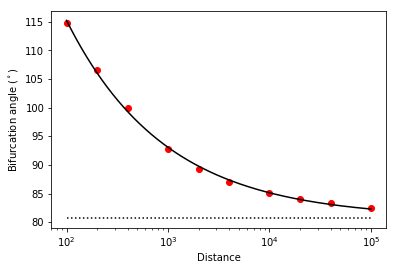

In [6]:
plt.scatter(distances, b_angles, c='red')
plt.plot(10**(fit_x), fit_y, c='black')
plt.hlines(popt[2], xmin=1e2, xmax=1e5, linestyles='dotted')
plt.xscale('log')
plt.xlabel('Distance')
plt.ylabel('Bifurcation angle ($^\circ$)')
plt.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/angle_vs_distance.png', format='png', dpi=300)

### Visualise change in bifurcation point based on number of neurons in the decision ensemble

6
12
24
60
120
240
600


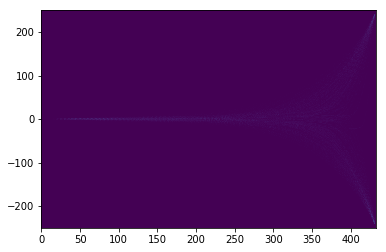

In [7]:
n_iters = 100
d = 500
b_angles = []

for n in neurons:
    df = pd.read_csv("/Users/vivekhsridhar/Documents/Work/Results/decision_geometry/Data/Theory/NN/neurons" + str(n) + ".csv")

    xs = np.array(df[' x'])
    ys = np.array(df[' y'] - 500)
    
    post0_x = d*np.cos(np.pi/6)
    post0_y = -d*np.sin(np.pi/6)
    post1_x = d*np.cos(np.pi/6)
    post1_y = d*np.sin(np.pi/6)
    
    img = density_map(xs, ys, stats=False)
    x_peaks = np.where(img > peak_threshold)[1] * post0_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post1_y) / nbins + post1_y
    
    params1 = np.zeros((n_iters, 2))
    
    for i in range(n_iters):
        x_fit = []
        y_fit = []

        indices = np.random.choice(len(xs), size=10000, replace=True)
        x_fit = xs[indices]
        y_fit = np.abs(ys[indices])

        fit_params, pcov = curve_fit(
            fitfunc_vec_self, x_fit, y_fit, p0=[3, 1], maxfev=10000
        )
        params1[i, :] = fit_params
    
    bif_angle = 2 * np.arctan2(post1_y, post1_x - np.median(params1, axis=0)[0]) * 180 / np.pi
    b_angles.append(bif_angle)
    print(n)

In [48]:
popt, pcov = curve_fit(exponenial_func, np.log10(neurons), b_angles, p0=(1000, -1, 100), maxfev=10000)

fit_x = np.linspace(0.78, 2.78, 1000)
fit_y = exponenial_func(fit_x, *popt)

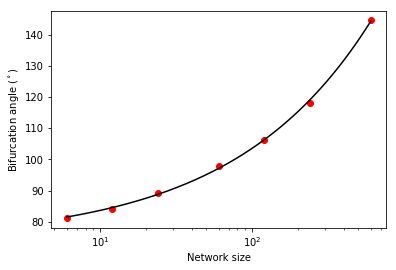

In [51]:
plt.scatter(neurons, b_angles, c='red')
plt.plot(10**(fit_x), fit_y, c='black')
#plt.hlines(popt[2], xmin=6e0, xmax=6e2, linestyles='dotted')
plt.xscale('log')
plt.xlabel('Network size')
plt.ylabel('Bifurcation angle ($^\circ$)')
plt.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/angle_vs_netsize.png', format='png', dpi=300)

### Visualise angle as the control parameter

In [10]:
df = pd.read_csv("/Users/vivekhsridhar/Documents/Work/Results/decision_geometry/Data/Theory/NN/geom_t2_diff0.csv")

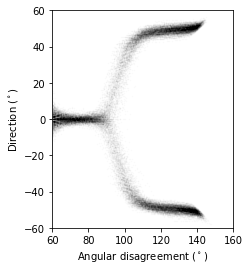

In [11]:
plt.scatter(df[' angular_disagreement'], np.arctan2(df[' dir_y'], df[' dir_x']) * 180/np.pi, c='black', s=1, alpha=0.01)
plt.xlim(60,160)
plt.ylim(-60,60)
plt.gca().set_aspect('equal')
plt.xlabel('Angular disagreement ($^\circ$)')
plt.ylabel('Direction ($^\circ$)')
plt.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/bifurcation_plot.png', format='png', dpi=300)